----------------------
#### RAG with evaluation
---------------------

In [1]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown
from langchain.llms import OpenAI

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = r'OutdoorClothingCatalog_1000.csv'

In [3]:
df = pd.read_csv(file)

In [4]:
df.sample(5)

,Unnamed: 0,name,description
73,73,Cozy Cuddles Knit Pullover Set,"Perfect for lounging, this knit set lives up t..."
52,52,Women's Salomon Sense Adventure Trail Runner,These Salomon trail shoes offer a great fit an...
400,400,Mountain Crest Insulated Pullover,We took the classic anorak look and combined i...
887,887,Umpqua Pro Guide Lightweight Fly Storage Box,"This high capacity, lightweight fly box offers..."
937,937,Garmin eTrex Journeyer,The eTrex 20x is a handheld GPS that is a long...


In [5]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
# Compute lengths of 'name' and 'description' columns
df['name_len'] = df['name'].apply(len)
df['descp_len'] = df['description'].apply(len)
df

,name,description,name_len,descp_len
0,Women's Campside Oxfords,This ultracomfortable lace-to-toe Oxford boast...,24,724
1,"Recycled Waterhog Dog Mat, Chevron Weave",Protect your floors from spills and splashing ...,40,946
2,Infant and Toddler Girls' Coastal Chill Swimsu...,"She'll love the bright colors, ruffles and exc...",59,458
3,"Refresh Swimwear, V-Neck Tankini Contrasts",Whether you're going for a swim or heading out...,42,928
4,EcoFlex 3L Storm Pants,Our new TEK O2 technology makes our four-seaso...,22,1033
...,...,...,...,...
995,"Men's Classic Denim, Standard Fit",Crafted from premium denim that will last wash...,34,564
996,CozyPrint Sweater Fleece Pullover,The ultimate sweater fleece - made from superi...,33,782
997,Women's NRS Endurance Spray Paddling Pants,These comfortable and affordable splash paddli...,42,781
998,Women's Stop Flies Hoodie,This great-looking hoodie uses No Fly Zone Tec...,25,871


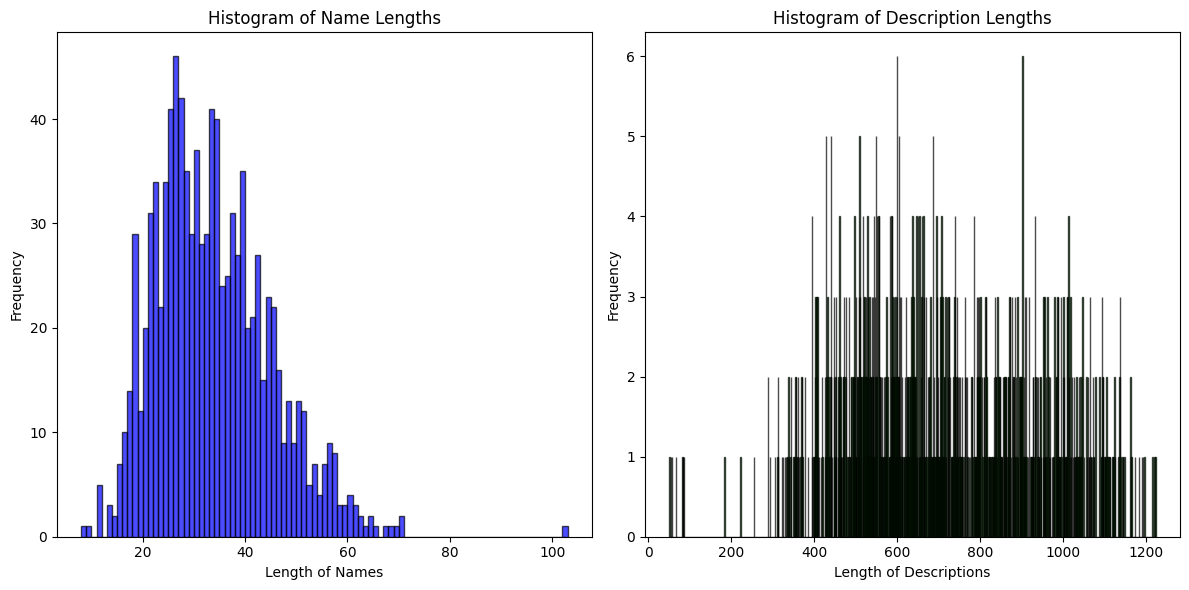

In [7]:
# Compute lengths of 'name' and 'description' columns
df['name_len'] = df['name'].apply(len)
df['descp_len'] = df['description'].apply(len)

# Plotting histograms for name_len and descp_len
plt.figure(figsize=(12, 6))

# Histogram for name_len
plt.subplot(1, 2, 1)
plt.hist(df['name_len'], bins=range(df['name_len'].min(), df['name_len'].max() + 2), alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Name Lengths')
plt.xlabel('Length of Names')
plt.ylabel('Frequency')

# Histogram for descp_len
plt.subplot(1, 2, 2)
plt.hist(df['descp_len'], bins=range(df['descp_len'].min(), df['descp_len'].max() + 2), alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of Description Lengths')
plt.xlabel('Length of Descriptions')
plt.ylabel('Frequency')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

In [8]:
df.describe()

,name_len,descp_len
count,1000.000000,1000.00000
mean,33.306000,706.81700
std,11.198472,223.46603
min,8.000000,51.00000
25%,25.000000,536.00000
50%,32.000000,686.00000
75%,40.000000,884.50000
max,102.000000,1223.00000


#### create embeddings for the descp col

In [9]:
from langchain_openai import OpenAIEmbeddings

In [10]:
emb_model = OpenAIEmbeddings(model= 'text-embedding-ada-002')

In [11]:
%%time
# Generate embeddings for each description
# Storing metadata separately
#vectors  = [emb_model.embed_query(row['description']) for _, row in df.iterrows()]

CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
# Generate embeddings for each description
metadata = [{'name': row['name'], 'description': row['description']} for _, row in df.iterrows()]

In [13]:
import pickle

In [14]:
# Pickling the DocList
# with open("vectors.pkl", "wb") as f:
#     pickle.dump(vectors, f)

In [15]:
# Unpickling the DocList
with open("vectors.pkl", "rb") as f:
    vectors = pickle.load(f)

In [16]:
type(vectors), len(vectors)

(list, 1000)

In [17]:
# Convert list of embeddings to a NumPy array
embedding_dim = len(vectors[0])                     # assuming all embeddings are the same size
vectors_np    = np.array(vectors, dtype='float32')

In [18]:
#pip install faiss-cpu

In [19]:
from langchain.vectorstores import FAISS

In [20]:
# Combine descriptions and their corresponding embeddings into tuples
text_embedding_pairs = list(zip(df['description'].tolist(), vectors_np))

In [21]:
metadata[:2]

[{'name': "Women's Campside Oxfords",
  'description': 'This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.'},
 {'name': 'Recycled Waterhog Dog Mat, Chevron Weave',
  'description': 'Protect your floors from spills and splashing with our ultradurable recycled Waterhog dog mat made right here in the USA. \n\nSpecs\nSma

In [22]:
vector_store = FAISS.from_embeddings(
    text_embeddings = text_embedding_pairs,          # The list of embeddings
    embedding       = emb_model,                     # The embedding model instance
    metadatas       = metadata                       # Metadata to attach with each embedding
)

In [23]:
# Define your query
query = "Chain-tread-inspired molded rubber outsole"

In [24]:
results = vector_store.similarity_search(query=query, k=5)

In [25]:
for result in results:
    #print("Document Content:", result.page_content)  # Content of the retrieved document
    print("\nMetadata:", result.metadata)  # Metadata associated with the document


Metadata: {'name': "Mens' Wanderer Trek Shoes, Suede", 'description': 'These casual, mountain-town-style shoes have sneaker-like comfort and performance features. Constructed with a suede-leather upper that resists water, the shoes feature a thick EVA midsole and sock liner for cushioning and comfort that last all day. The sock liner is treated to control odor, and the Vertigrip rubber outsole has subtle lugs for traction on slick surfaces and short hikes. Imported.'}

Metadata: {'name': "Men's Summit Trail Waterproof Hiking Shoes", 'description': 'Enjoy the comfort of sneakers and the protection and support of hiking boots with ’s exclusive VertiGrip outsole. The outsole has pronounced multidirectional lugs for maximum traction. The breathable TEK2.5 barrier keeps feet dry. The suede-and-fabric upper, cushioned EVA midsole and removable footbed provide noticeable comfort right out of the box. Heel-and-toe bumpers add durability. Approx. weight: 2 lb. 5 oz. This versatile footwear is 

In [26]:
query = "Please suggest a shirt with sunblocking"

In [27]:
sim_docs = vector_store.similarity_search(query)

In [28]:
for result in sim_docs:
    #print("Document Content:", result.page_content)  # Content of the retrieved document
    print("\nMetadata:", result.metadata)  # Metadata associated with the document


Metadata: {'name': "Women's Tropical Tee, Sleeveless", 'description': "Our five-star sleeveless button-up shirt has a fit to flatter and SunSmart™ protection to block the sun’s harmful UV rays. Size & Fit: Slightly Fitted: Softly shapes the body. Falls at hip. Fabric & Care: Shell: 71% nylon, 29% polyester. Cape lining: 100% polyester. Built-in SunSmart™ UPF 50+ rated – the highest rated sun protection possible. Machine wash and dry. Additional Features: Updated design with smoother buttons. Wrinkle resistant. Low-profile pockets and side shaping offer a more flattering fit. Front and back cape venting. Two front pockets, tool tabs and eyewear loop. Imported. Sun Protection That Won't Wear Off: Our high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun's harmful rays."}

Metadata: {'name': 'Sun Shield Shirt by ', 'description': '"Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \n\nSize & Fit: Slightly

#### Use the retrievers

In [30]:
llm_model = "gpt-3.5-turbo"

llm = ChatOpenAI(temperature = 0.0, model=llm_model)

In [31]:
# Convert the FAISS vector store to a retriever
retriever = vector_store.as_retriever()

In [38]:
retriever.search_kwargs = {"k": 15}     # Retrieve top 10 documents

In [39]:
qa_chain = RetrievalQA.from_chain_type(
    llm        = llm,             # The language model you want to use (e.g., OpenAI's GPT)
    chain_type = "stuff",         # Choose the chain type; options include "stuff", "map_reduce", etc.
    retriever  = retriever,
    verbose    = True
)

In [40]:
query =  "Please list all your shirts with sun protection in a table \
in markdown and summarize each one."

In [41]:
response = qa_chain.invoke(query)



> Entering new RetrievalQA chain...

> Finished chain.


In [42]:
result_text = response['result']
display(Markdown(result_text))

| Shirt Type | Summary |
|------------|---------|
| Men's Sun Protection Shirt | Lightweight, UPF 50+ rated, wrinkle-resistant, with front and back cape venting, two front bellows pockets, and made of 71% nylon, 29% polyester. |
| Women's UV-Protective Button Down Shirt | Lightweight, UPF 50+ rated, moisture-wicking, wrinkle-free, with front and back cape venting, two front pockets, and made of 71% nylon, 29% polyester. |
| Men's Long-Sleeve Quarter-Zip Cycling Shirt | Quick-drying, UPF 40+ rated, antimicrobial, with a quarter-zip front, back pouch pocket, and made of 100% Airtek polyester. |
| Men's Long-Sleeve Sun-Protection Shirt | UPF 50+ rated, wrinkle-resistant, moisture-wicking, with front and back cape venting, and made of 71% nylon, 29% polyester. |
| Men's Sun-Protection Shirt | UPF 50+ rated, lightweight, wrinkle-free, quick-drying, with front and back cape venting, two front bellows pockets, and made of 52% polyester, 48% nylon. |
| Women's Sun-Protection Button-Up Shirt | UPF 50+ rated, moisture-wicking, wrinkle-resistant, with front and back cape venting, two front pockets, and made of 71% nylon, 29% polyester. |
| Girls' Swim Shirt | UPF 50+ rated, snag- and fade-resistant, seawater-resistant, and made of 80% nylon, 20% Lycra Xtra Life. |
| Sleeveless Button-Up Shirt | UPF 50+ rated, wrinkle-resistant, low-profile pockets, side shaping, front and back cape venting, and made of 71% nylon, 29% polyester. |
| Technical Fishing Shirt | UPF 50+ rated, No Fly Zone technology, moisture-wicking, quick-drying, with four chest pockets, and made of 94% nylon, 6% spandex. |
| Lightweight Linen Shirt | Lightweight, breathable, with a single patch pocket, and made of 100% linen. |
| Sun-Blocking Baseball Hat | UPF 50+ rated, rear flap for extra coverage, elastic cord for adjustment, coolmax sweatband, and made of 71% nylon, 29% polyester. |

#### How Stuff Chains Work

##### Input Documents
When you make a query through your retriever, it returns a set of relevant documents based on the embeddings. These documents might contain various pieces of information relevant to your query.

##### Combining Documents
The Stuff Chain takes these retrieved documents and concatenates their contents into a single input string. This allows the next step in the chain to have access to all the relevant information in one place, rather than processing each document individually.

##### Prompting the Language Model
Once the documents are combined, this unified text is then fed into a language model (like GPT-3 or GPT-4) as part of the input. The model can then generate a response based on the combined context. The prompt given to the model can be designed to summarize the information, answer specific questions, or format it in a particular way (like generating a table).

##### Output Generation
The output from the language model is the final response, which could be a summary, a detailed answer, or formatted content like tables or bullet points, depending on how you've designed the prompt.

#### Evaluate the quality of the QnA response